In [1]:
import os
import sys
import numpy as np
import argparse
import subprocess
import json
import time
import scipy
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d

import nibabel as nib
import bigbadbrain as bbb
import dataflow as flow

from skimage.filters import threshold_triangle as tri_thresh
from skimage.filters import threshold_yen as yen_thresh
from skimage.filters import threshold_isodata as iso_thresh
from skimage.filters import threshold_li as li_thresh

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
directory = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_087/func_0" # full fly func path
file = "brain_zscored_green_high_pass_masked.nii"

brain_file = os.path.join(directory, file)

### Load Brain ###
brain = np.array(nib.load(brain_file).get_data(), copy=True)

### Load brain to use as mask ###
brain_file = os.path.join(directory, 'imaging', 'functional_channel_1_mean.nii')
brain_mean = np.array(nib.load(brain_file).get_data(), copy=True)

In [4]:
# Custom auto-threshold finder; trained a linear model
yen = yen_thresh(brain_mean,nbins=1000)
tri = tri_thresh(brain_mean)
iso = iso_thresh(brain_mean,nbins=1000)
li = li_thresh(brain_mean)
threshold = 0.00475597*tri + 0.01330587*yen + -0.04362137*iso + 0.1478071*li + 36.46
brain_mean[np.where(brain_mean < threshold)] = 0

In [5]:
# Erode to remove extra-brain regions
brain_mean = ndimage.binary_erosion(brain_mean, structure=np.ones((5,5,1)))

# Find blobs not contiguous with largest blob
labels, label_nb = scipy.ndimage.label(brain_mean)
brain_label = np.bincount(labels.flatten())[1:].argmax()+1
mask = np.ones(brain_mean.shape)
mask[np.where(labels != brain_label)] = 0 # np.nan here failed with PCA

In [6]:
# Undo previous erosion
mask = ndimage.binary_dilation(mask, structure=np.ones((5,5,1))).astype(int)

In [7]:
# Mask edges with zeros
mask[:,(0,1,-1,-2),:] = 0
mask[(0,1,-1,-2),:,:] = 0
mask[:,:,(0,-1)] = 0

In [8]:
### save mask ###
brain_save_file = os.path.join(directory, 'mask.nii')
nib.Nifti1Image(mask, np.eye(4)).to_filename(brain_save_file)

In [4]:
mask.shape

(256, 128, 49)

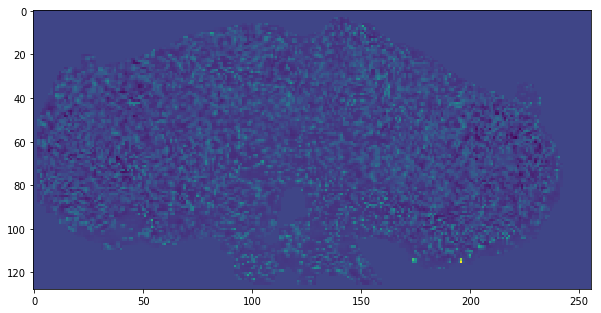

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,20,1000].T)

In [7]:
brain = brain*mask[:,:,:,None]

In [8]:
### Save Brain ###
brain_save_file = os.path.join(directory, 'brain_zscored_green_high_pass_masked.nii')
nib.Nifti1Image(brain, np.eye(4)).to_filename(brain_save_file)